In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup 
import re
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

## Helper Functions

In [96]:
def pull_results(Bsoup):
    clean = []
    pull = Bsoup.findAll('span', attrs={'class': re.compile("icon(.*?)square")})

    # Clean to make useable 
    for i in pull:
        if 'minus' in str(i): 
            clean.append('loss')
        elif 'plus' in str(i): 
            clean.append('win')
        elif 'equal' in str(i):
            clean.append('draw')
        else:
            clean.append('error')
    
    return clean
    

In [100]:
def pull_moves(Bsoup):
    moves = []
    for i in Bsoup.findAll('td', attrs={'class': re.compile("table-text-center")}):
        if i.find('span'):
            moves.append(int(i.find('span').text))
    
    return moves

In [105]:
def pull_dates(Bsoup):
    dates = []
    for i in Bsoup.findAll('td', attrs={'class': re.compile("table-text-right archive-games-date-cell")}):
        dates.append(i.getText().strip())
    
    return dates

In [116]:
def pull_speed(Bsoup):
    times = []
    for i in b.findAll('span', attrs={'class': re.compile("archive-games-game-time")}):
        times.append((i.getText().strip()))
    
    return times

In [113]:
def remove_dups(duplicate): 
    final_list = [] 
    for num in duplicate: 
        if num not in final_list: 
            final_list.append(num) 
    return final_list 

In [114]:
def pull_game_links(Bsoup):
    links = []
    for i in b.findAll('td', attrs={'class': re.compile("table-text-center archive-games-analyze-cell")}):
        for j in i.findAll('a'):
            links.append(j.get('href'))
            
    return remove_dups(links)

In [493]:
def find_color(text):
    if 'white' in str(text):
        return 'white'
    elif 'black' in str(text):
        return 'black'
    else:
        return 'error'

In [503]:
def pull_player_stats(Bsoup):
    my_elo_lst = []
    opponent_elo_lst = []
    opponent_country_lst = []
    opponent_name_lst = []
    my_color_lst = []
    for cell in b.findAll('td', {'class':'archive-games-user-cell'}):
        # Split the halves
        top_half = cell.findAll('div', {'class': 'post-view-meta-user'})[0]
        bottom_half = cell.findAll('div', {'class': 'post-view-meta-user'})[1]
        
        top_color = find_color(cell.findAll('span')[0])
        bottom_color = find_color(cell.findAll('span')[2])
        
        # Logic to see if I'm top player or bottom player
        if top_half.text.strip().split('\n')[0] == 'eono619':
            my_elo= top_half.find('span', {'class':'post-view-meta-rating'}).text
            my_color= top_color
            opponent_elo = bottom_half.find('span', {'class':'post-view-meta-rating'}).text
            opponent_country = bottom_half.find('div').get('v-tooltip')
            opponent_name = bottom_half.text.strip().split('\n')[0]
        else: 
            my_elo= bottom_half.find('span', {'class':'post-view-meta-rating'}).text
            my_color= bottom_color
            opponent_elo = top_half.find('span', {'class':'post-view-meta-rating'}).text
            opponent_country = top_half.find('div').get('v-tooltip')
            opponent_name = top_half.text.strip().split('\n')[0]        
        
        # Clean
        my_elo = int(my_elo.replace('(','').replace(')', ''))
        opponent_elo = int(opponent_elo.replace('(','').replace(')', ''))
        opponent_country = opponent_country.replace("'", "")
        
        # Gather data 
        my_elo_lst.append(my_elo)
        my_color_lst.append(my_color)
        opponent_elo_lst.append(opponent_elo)
        opponent_country_lst.append(opponent_country)
        opponent_name_lst.append(opponent_name)

    return(my_elo_lst, opponent_elo_lst, opponent_country_lst, opponent_name_lst, my_color_lst)

## Scrape, Inspect Data, Save

In [511]:
# Initialize
results = []
moves = []
dates = []
speed = []
games = []
my_elo = []
my_color = []
opponent_elo = []
opponent_country = []
opponent_name = []

for i in range(1,33):
    # Get the page
    text = requests.get("""https://www.chess.com/games/archive/eono619?
                gameOwner=other_game&gameTypes%5B0%5D=chess960
                &gameTypes%5B1%5D=daily&gameType=live&page={}""".format(i)).text
    # Soupify
    b = BeautifulSoup(text, 'html.parser')
    
    # Collect results
    results += pull_results(b)
    moves += pull_moves(b)
    dates += pull_dates(b)
    speed += pull_speed(b)
    games += pull_game_links(b)
    my_elo += pull_player_stats(b)[0]
    opponent_elo += pull_player_stats(b)[1]
    opponent_country += pull_player_stats(b)[2]
    opponent_name += pull_player_stats(b)[3]
    my_color += pull_player_stats(b)[4]
    
    # Check progress
    print(i)
    
# Make Df
d = {'date': dates,
     'result': results,
     'moves': moves,
     'speed': speed,
     'link': games,
     'my_elo': my_elo,
     'opponent_elo': opponent_elo,
     'opponent_country': opponent_country,
     'opponent_name': opponent_name,
     'color': my_color
}

games_df = pd.DataFrame(d)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [475]:
games_df.shape

(1566, 9)

In [515]:
games_df.head()

,color,date,link,moves,my_elo,opponent_country,opponent_elo,opponent_name,result,speed
0,white,"Sep 22, 2019",https://www.chess.com/analysis/game/live/40557...,23,1204,United States,1141,wmtw,win,5 min
1,white,"Sep 22, 2019",https://www.chess.com/analysis/game/live/40552...,30,1197,Norway,1210,hanne-lm,loss,5 min
2,black,"Sep 21, 2019",https://www.chess.com/analysis/game/live/40532...,53,1205,Canada,1193,keenen1995,win,5 min
3,black,"Sep 21, 2019",https://www.chess.com/analysis/game/live/40524...,53,1197,Spain,1203,plinio2015,win,5 min
4,black,"Sep 21, 2019",https://www.chess.com/analysis/game/live/40520...,45,1188,Morocco,1212,anjjar,win,5 min


In [19]:
# Write to .csv for future use
#games_df.to_csv(path_or_buf='chess_games.csv')

In [20]:
games_df = pd.read_csv('chess_games.csv', index_col=0)
games_df.head()

,color,date,link,moves,my_elo,opponent_country,opponent_elo,opponent_name,result,speed
0,white,"Sep 22, 2019",https://www.chess.com/analysis/game/live/40557...,23,1204,United States,1141,wmtw,win,5 min
1,white,"Sep 22, 2019",https://www.chess.com/analysis/game/live/40552...,30,1197,Norway,1210,hanne-lm,loss,5 min
2,black,"Sep 21, 2019",https://www.chess.com/analysis/game/live/40532...,53,1205,Canada,1193,keenen1995,win,5 min
3,black,"Sep 21, 2019",https://www.chess.com/analysis/game/live/40524...,53,1197,Spain,1203,plinio2015,win,5 min
4,black,"Sep 21, 2019",https://www.chess.com/analysis/game/live/40520...,45,1188,Morocco,1212,anjjar,win,5 min


In [21]:
# convert dates to datetime 
games_df.set_index(games_df.index[::-1], drop=True, inplace=True)
games_df['date'] = pd.to_datetime(games_df['date'])

In [22]:
speed_games = games_df[games_df.speed=='5 min']
speed_games.reset_index(drop=True, inplace=True)
speed_games.set_index(speed_games.index[::-1], drop=True, inplace=True)

In [23]:
speed_games['my_elo_ma'] = speed_games['my_elo'][::-1].rolling(window=30).mean()
speed_games['result'] = pd.Series(np.where(speed_games.result.values == 'win', 1, 0), speed_games.index)
speed_games.head(50)

/Users/Eric/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/Eric/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,color,date,link,moves,my_elo,opponent_country,opponent_elo,opponent_name,result,speed,my_elo_ma
1332,white,2019-09-22,https://www.chess.com/analysis/game/live/40557...,23,1204,United States,1141,wmtw,1,5 min,1144.666667
1331,white,2019-09-22,https://www.chess.com/analysis/game/live/40552...,30,1197,Norway,1210,hanne-lm,0,5 min,1141.900000
1330,black,2019-09-21,https://www.chess.com/analysis/game/live/40532...,53,1205,Canada,1193,keenen1995,1,5 min,1139.666667
1329,black,2019-09-21,https://www.chess.com/analysis/game/live/40524...,53,1197,Spain,1203,plinio2015,1,5 min,1137.466667
1328,black,2019-09-21,https://www.chess.com/analysis/game/live/40520...,45,1188,Morocco,1212,anjjar,1,5 min,1135.333333
1327,white,2019-09-21,https://www.chess.com/analysis/game/live/40520...,27,1179,Saudi Arabia,1169,aliekhwan,1,5 min,1133.200000
1326,white,2019-09-20,https://www.chess.com/analysis/game/live/40501...,47,1171,United States,1146,antilleschris,1,5 min,1131.133333
1325,white,2019-09-20,https://www.chess.com/analysis/game/live/40495...,37,1163,India,1156,madhuekambaram,1,5 min,1129.066667
1324,black,2019-09-19,https://www.chess.com/analysis/game/live/40464...,61,1155,United States,1002,vitaliyhoryn,1,5 min,1127.533333
1323,black,2019-09-19,https://www.chess.com/analysis/game/live/40462...,21,1150,India,1161,ycRaghav,1,5 min,1125.966667


## Visualize

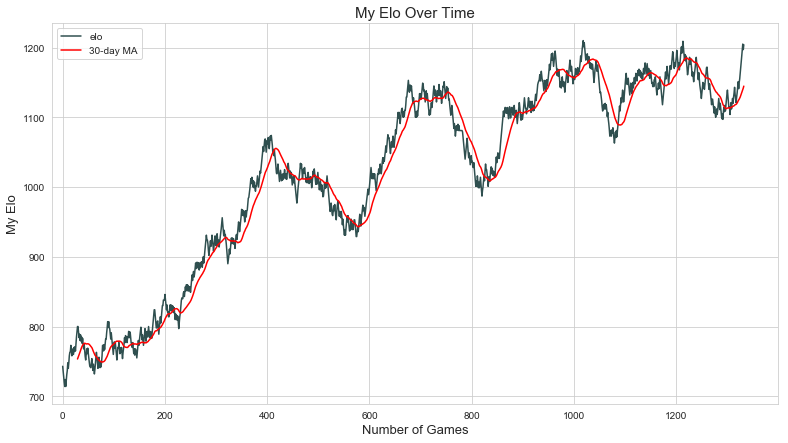

In [24]:
sns.set_style("whitegrid")
plt.figure(figsize=(13, 7))

sns.lineplot(y='my_elo', 
             x=speed_games.index,
             data=speed_games, 
             color='darkslategray')

sns.lineplot(y='my_elo_ma', 
             x=speed_games.index,
             data=speed_games, 
             color='red')

plt.xlabel('Number of Games', fontsize=13)
plt.ylabel('My Elo', fontsize=13)
plt.title('My Elo Over Time', fontsize=15)
plt.xlim(-20)

plt.legend(['elo', '30-day MA'])
plt.savefig('elo_graph.png')

plt.show()

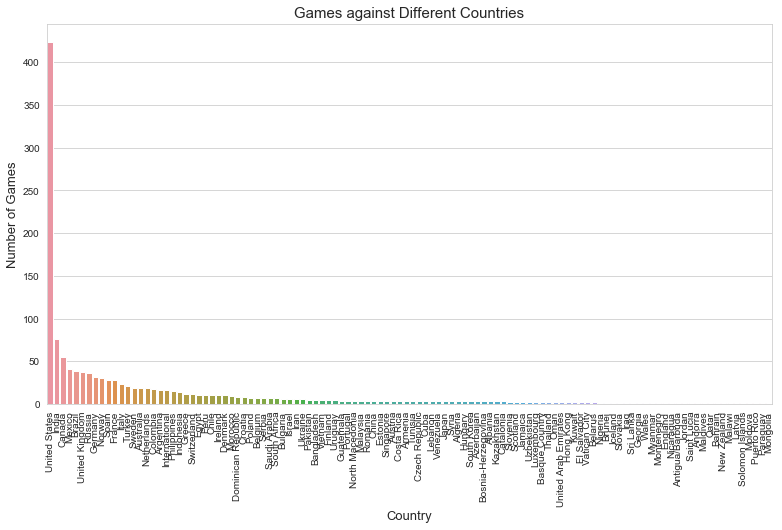

In [25]:
sns.set_style("whitegrid")
plt.figure(figsize=(13, 7))

sns.countplot('opponent_country', data=speed_games, 
             order = speed_games['opponent_country'].value_counts().index)

plt.xlabel('Country', fontsize=13)
plt.ylabel('Number of Games', fontsize=13)
plt.title('Games against Different Countries', fontsize=15)

plt.xticks(rotation=90)

plt.savefig('country_full.png')
plt.show()



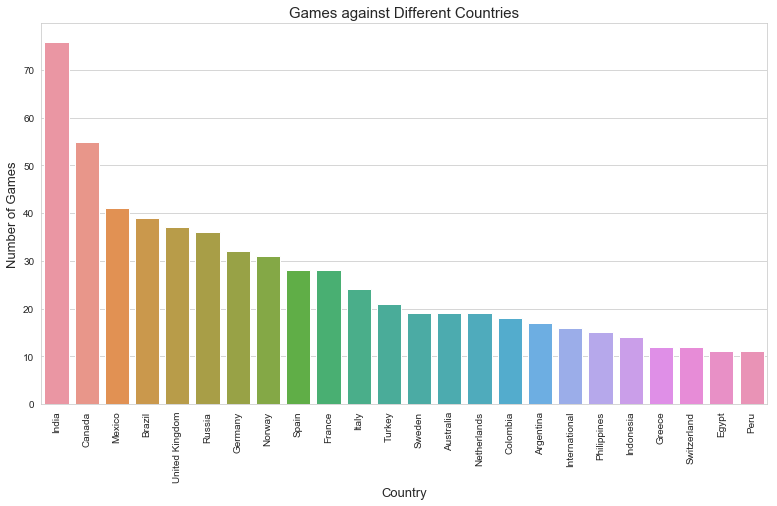

In [26]:
sns.set_style("whitegrid")
plt.figure(figsize=(13, 7))

sns.countplot('opponent_country', data=speed_games, 
             order = speed_games['opponent_country'].value_counts().iloc[1:25].index)

plt.xlabel('Country', fontsize=13)
plt.ylabel('Number of Games', fontsize=13)
plt.title('Games against Different Countries', fontsize=15)

plt.xticks(rotation=90)
plt.savefig('country_trunc.png')

plt.show()

In [27]:
month_counts = speed_games.resample('M', on='date').count()
week_counts = speed_games.resample('W', on='date').count()
day_counts = speed_games.resample('D', on='date').count()

dow_average = speed_games.groupby(speed_games['date'].dt.weekday_name).mean()
dow_count = speed_games.groupby(speed_games['date'].dt.weekday_name).count()

In [30]:
country_average = speed_games.groupby(speed_games['opponent_country']).mean()
country_count = speed_games.groupby(speed_games['opponent_country']).count()
country_stats = pd.DataFrame(country_average['result']).join(pd.DataFrame(country_count['my_elo']), how='inner')


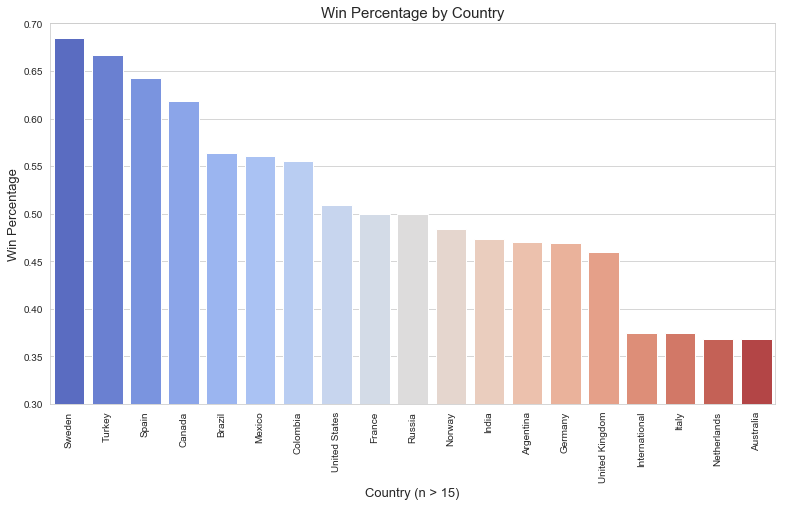

In [31]:
sns.set_style("whitegrid")
plt.figure(figsize=(13, 7))

sns.barplot(y='result',
            x=country_stats[country_stats.my_elo > 15].index,
            data=country_stats[country_stats.my_elo > 15],
            order=country_stats[country_stats.my_elo > 15].sort_values('result', ascending=False).index,
            palette="coolwarm"
           )

plt.xticks(rotation=90)
plt.ylim(.3,.7)

plt.xlabel('Country (n > 15)', fontsize=13)
plt.ylabel('Win Percentage', fontsize=13)
plt.title('Win Percentage by Country', fontsize=15)

plt.savefig('country_win_percent.png')

plt.show()

## Subplots

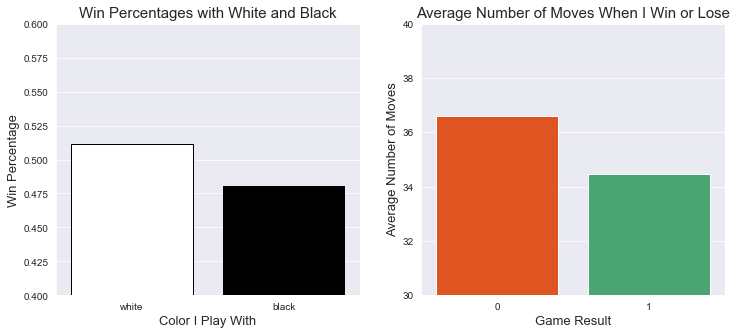

In [34]:
color_average = speed_games[speed_games.color != 'error'].groupby(speed_games['color']).mean()
win_average = speed_games.groupby(speed_games['result']).mean()

sns.set_style("darkgrid")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(y='result',
            x=color_average.index,
            data=color_average,
            order=['white', 'black'],
            palette=['white', 'black'],
            edgecolor=(0,0,0)
           )

plt.xlabel('Color I Play With', fontsize=13)
plt.ylabel('Win Percentage', fontsize=13)
plt.title('Win Percentages with White and Black', fontsize=15)
plt.ylim(.40, .60)


plt.subplot(1, 2, 2)
sns.barplot(y='moves',
            x=win_average.index,
            data=win_average,
            palette=['orangered', 'mediumseagreen'],
           )

plt.xlabel('Game Result', fontsize=13)
plt.ylabel('Average Number of Moves', fontsize=13)
plt.title('Average Number of Moves When I Win or Lose', fontsize=15)
#plt.xticks(labels=('Loss', 'Win'))
plt.ylim(30,40)

plt.savefig('colors_results.png')

plt.show()

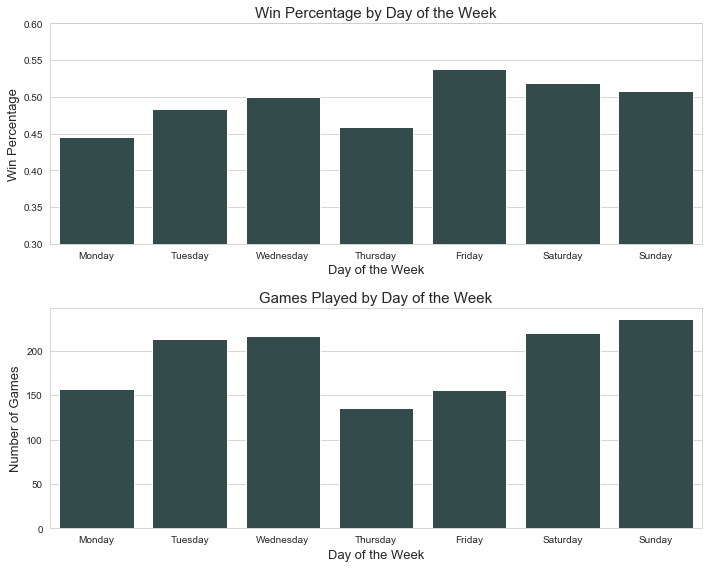

In [35]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.barplot(y='result',
            x=dow_average.index,
            data=dow_average,
            #order=dow_average.sort_values('result', ascending=False).index,
            order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
            color="darkslategray"
           )

plt.xticks(rotation=0)
plt.ylim(.3,.6)

plt.xlabel('Day of the Week', fontsize=13)
plt.ylabel('Win Percentage', fontsize=13)
plt.title('Win Percentage by Day of the Week', fontsize=15)

plt.subplot(2, 1, 2)
sns.barplot(y='result',
            x=dow_count.index,
            data=dow_count,
            #order=dow_average.sort_values('result', ascending=False).index,
            order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
            color="darkslategray"
           )

plt.xticks(rotation=0)

plt.xlabel('Day of the Week', fontsize=13)
plt.ylabel('Number of Games', fontsize=13)
plt.title('Games Played by Day of the Week', fontsize=15)

plt.tight_layout(h_pad=1.5)

plt.savefig('dow_stats.png')

plt.show()

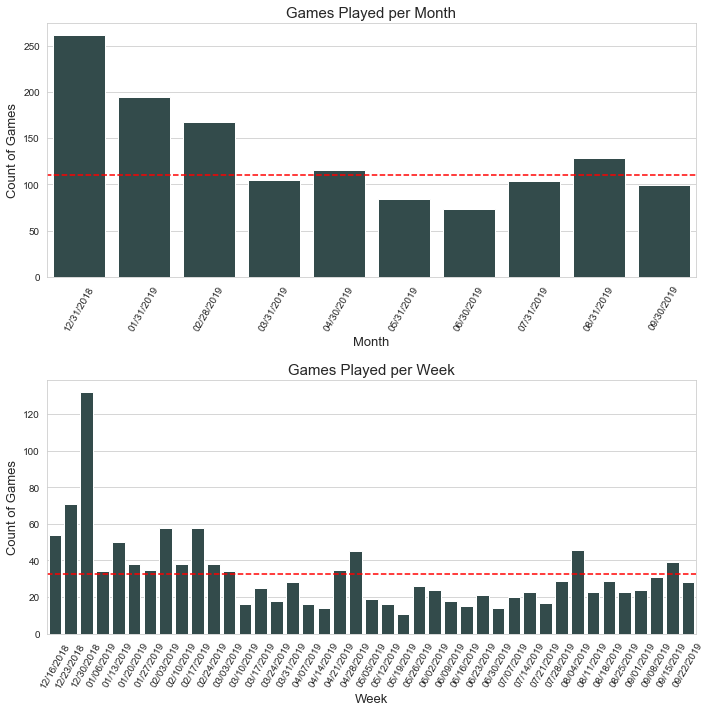

In [36]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.hlines(y=110.5, 
           colors='red',
           xmin=-1,
           xmax=len(speed_games),
           linestyles='dashed')

sns.barplot(x=[x.strftime("%m/%d/%Y") for x in month_counts.index],
            y=month_counts.date,
            color='darkslategray')

plt.xlabel('Month', fontsize=13)
plt.ylabel('Count of Games', fontsize=13)
plt.title('Games Played per Month', fontsize=15)
plt.xticks(rotation=60)

plt.subplot(2, 1, 2)
plt.hlines(y=32.46, 
           colors='red',
           xmin=-1,
           xmax=50,
           linestyles='dashed')

sns.barplot(x=[x.strftime("%m/%d/%Y") for x in week_counts.index],
            y=week_counts.date,
            color='darkslategray')

plt.xlabel('Week', fontsize=13)
plt.ylabel('Count of Games', fontsize=13)
plt.title('Games Played per Week', fontsize=15)

plt.xticks(rotation=60)

plt.tight_layout(h_pad=1.5)

plt.savefig('m_w_counts.png')

plt.show()